<a href="https://colab.research.google.com/github/chenxuhe79/Statistics-and-data-analysis/blob/master/hyperopt_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Example with hyperopt module
created on 2022-04-22 <br>
https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce <br>
updated on 2022-12-24 for pickle package

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

In [ ]:
from IPython.display import Image
import seaborn as sns
import pandas as pd
import numpy as np
import pydotplus
import io
import pickle

from sklearn import base, metrics, model_selection, preprocessing, tree, utils
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale, normalize

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.set(style="whitegrid", palette="husl")
iris = sns.load_dataset("iris")
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


<AxesSubplot:xlabel='measurement', ylabel='value'>

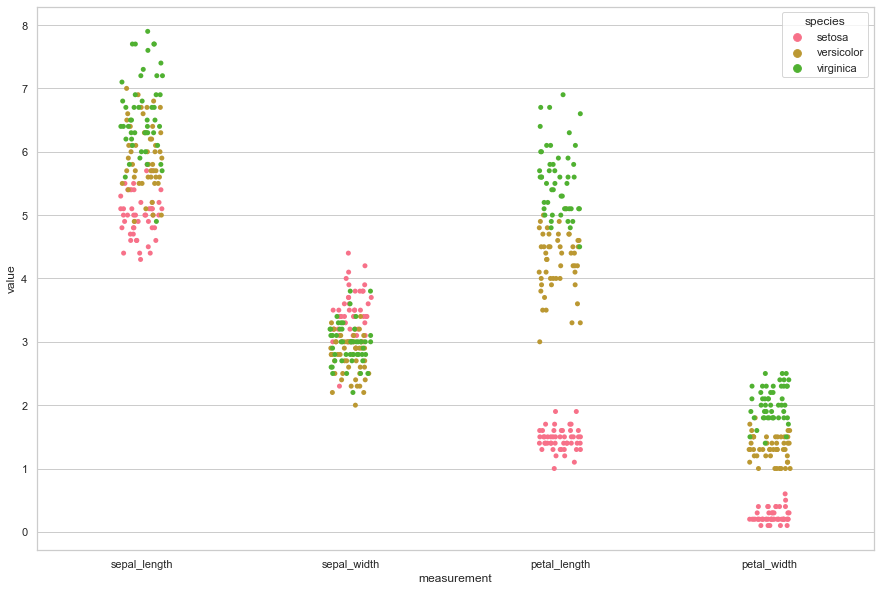

In [ ]:
iris = pd.melt(iris, "species", var_name="measurement")
print(iris.head())
f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax)

#### kNN classifier

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
X.shape, y.shape

((150, 4), (150,))

In [ ]:
def hyperopt_train_test(params):
    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,20))}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)
print('best:', best)

100%|██████████| 100/100 [00:01<00:00, 87.56trial/s, best loss: -0.9800000000000001]
best: {'n_neighbors': 5}


Text(0, 0.5, 'cross validation accuracy')

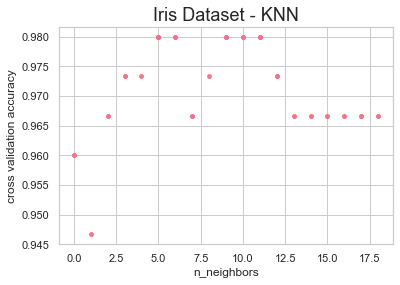

In [ ]:
f, ax = plt.subplots(1)#, figsize=(10,10))

xs = [t['misc']['vals']['n_neighbors'] for t in trials.trials]
ys = [-t['result']['loss'] for t in trials.trials]
ax.scatter(xs, ys, s=20, linewidth=0.01, alpha=0.7)
ax.set_title('Iris Dataset - KNN', fontsize=18)
ax.set_xlabel('n_neighbors', fontsize=12)
ax.set_ylabel('cross validation accuracy', fontsize=12)

In [ ]:
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']

    clf = KNeighborsClassifier(**params)
    return cross_val_score(clf, X_, y).mean()

space4knn = {
    'n_neighbors': hp.choice('n_neighbors', range(1,10)),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4knn, algo=tpe.suggest, max_evals=100, trials=trials)

print('best:',best)

100%|██████████| 100/100 [00:01<00:00, 77.51trial/s, best loss: -0.9800000000000001]
best: {'n_neighbors': 3, 'normalize': 1, 'scale': 0}


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


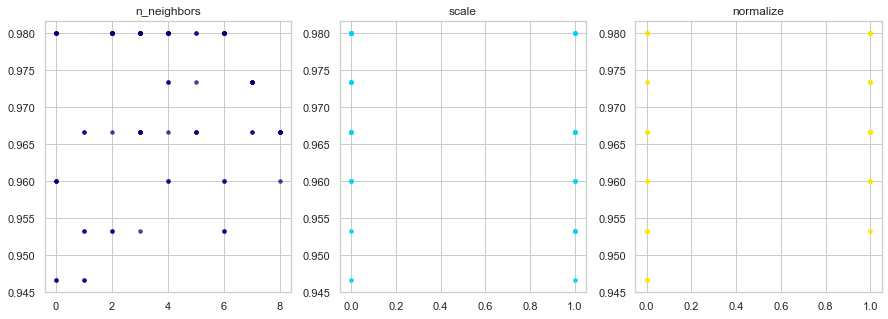

In [ ]:
parameters = ['n_neighbors', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

#### Decision Tree

In [ ]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
def hyperopt_train_test(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']

    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X, y).mean()

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    #'max_features': hp.choice('max_features', range(1,5)),
    #'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}
def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4dt, algo=tpe.suggest, max_evals=300, trials=trials)
print('best:',best)

100%|██████████| 300/300 [00:02<00:00, 115.09trial/s, best loss: -0.9733333333333334]
best: {'max_depth': 2, 'normalize': 1, 'scale': 1}


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


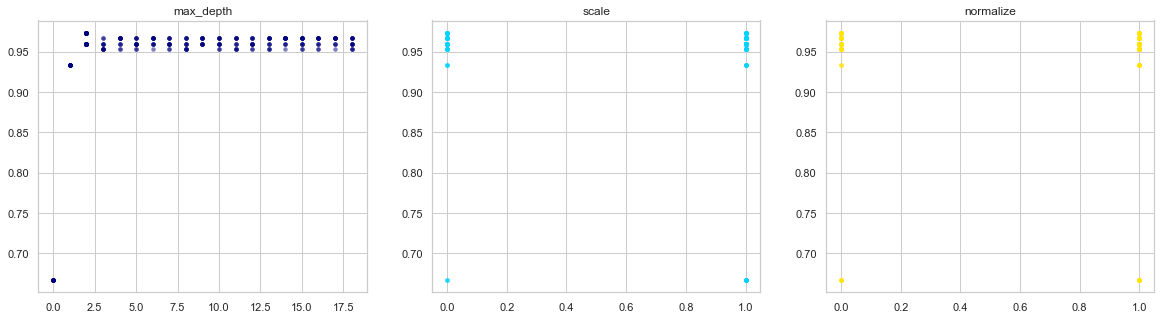

In [ ]:
#parameters = ['max_depth', 'max_features', 'criterion', 'scale', 'normalize'] # decision tree
parameters = ['max_depth', 'scale', 'normalize']
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])

### Binary classification

In [ ]:
iris = datasets.load_iris()

In [ ]:
X_bin = iris.data[iris.target!=0]
y_bin = iris.target[iris.target!=0]
y_bin = y_bin - 1

In [ ]:
feature_names = iris.feature_names
print(feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [ ]:
y_bin_labels = iris.target_names[1:]
print(y_bin_labels)

['versicolor' 'virginica']


In [ ]:
def model_report(model,X,y,y_labels = y_bin_labels):
    model_name = model.__class__.__name__
    y_predict = model.predict(X)
    y_predict_proba = model.predict_proba(X)[:,1]
    print(f"Accuracy: {metrics.accuracy_score(y,y_predict):.6f}, Precision: \
{metrics.precision_score(y,y_predict):.6f}, Recall: {metrics.recall_score(y,y_predict):.6f}.")
    #print("Area under ROC: ", metrics.roc_auc_score(y,y_predict_proba))
    roc_auc = metrics.roc_auc_score(y,y_predict_proba)
    ap = metrics.average_precision_score(y,y_predict_proba)

    cm = metrics.confusion_matrix(y,y_predict)
    
    fig, [ax_cm, ax_pr, ax_roc] = plt.subplots(1, 3, figsize=(16, 5))
    
    metrics.ConfusionMatrixDisplay(cm,display_labels = y_bin_labels).plot(cmap='Blues',ax = ax_cm,colorbar=False)
    ax_cm.grid(False)
    
    PR_disp = metrics.PrecisionRecallDisplay.from_estimator(model,X,y,name = model_name,
        label=model_name+"(AP = %0.4f)" % ap, ax = ax_pr)
    ax_pr.set_title("Precision cecall curve: "+model_name)
    ax_pr.legend(loc = "upper right")
    ax_pr.set_xlabel("Recall")
    ax_pr.set_ylabel("Precision")

    metrics.RocCurveDisplay.from_estimator(model, X, y,
            color="darkorange",lw=2,label="ROC curve (area = %0.4f)" % roc_auc,ax = ax_roc)
    ax_roc.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel("False Positive Rate")
    ax_roc.set_ylabel("True Positive Rate")
    ax_roc.set_title("Receiver operating characteristic: "+model_name)
    ax_roc.legend(loc="lower right")

In [ ]:
print(X_bin.shape, y_bin.shape)
y_bin[y_bin==0].shape

(100, 4) (100,)


(50,)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_bin, y_bin, random_state=42, test_size=.3)

In [ ]:
depth_list = [1,2,3,4,5,6]
auc_train_list = []
auc_test_list = []
for depth in depth_list:
    dtc = tree.DecisionTreeClassifier(max_depth=depth)
    dtc.fit(X_train, y_train)
    auc_train_list.append(metrics.roc_auc_score(y_train,dtc.predict_proba(X_train)[:,1]))
    auc_test_list.append(metrics.roc_auc_score(y_test,dtc.predict_proba(X_test)[:,1]))

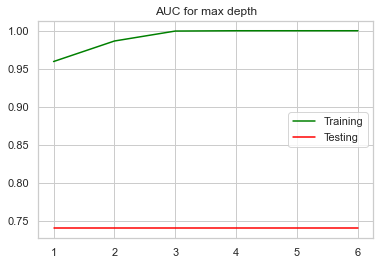

In [ ]:
plt.plot(depth_list, auc_train_list, color = 'green',label='Training')
plt.plot(depth_list, auc_test_list, color = 'red',label = 'Testing')
plt.title('AUC for max depth')
plt.legend()

In [ ]:
dtc = tree.DecisionTreeClassifier(max_depth = 2)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

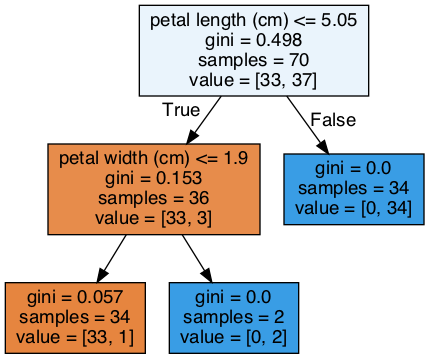

In [ ]:
dot_data = io.StringIO()
tree.export_graphviz(dtc, out_file=dot_data, feature_names=feature_names, filled=True, max_depth = 2)
g = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(g.create_png())

In [ ]:
X_train.shape

(70, 4)

Accuracy: 0.766667, Precision: 0.875000, Recall: 0.538462.


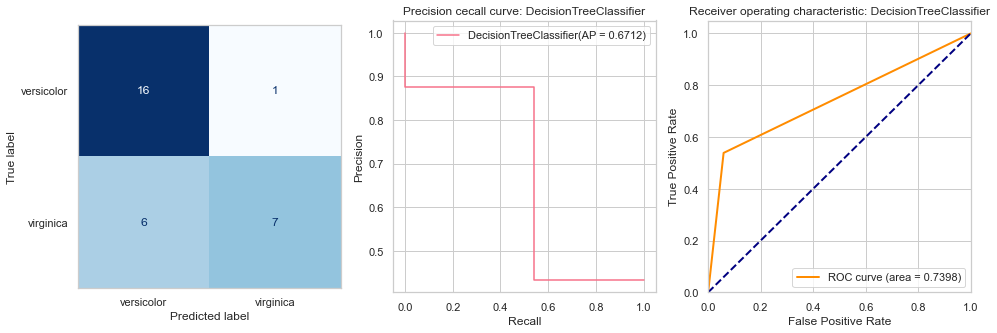

In [ ]:
model_report(dtc,X_test,y_test)

In [ ]:
def hyperopt_train_test(params):
    X_ = X_train[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']

    clf = DecisionTreeClassifier(**params)
    clf.fit(X_,y_train)
    y_predict_proba = clf.predict_proba(X_test)[:,1]
    return metrics.roc_auc_score(y_test,y_predict_proba)

space4dt = {
    'max_depth': hp.choice('max_depth', range(1,4)),
    #'max_features': hp.choice('max_features', range(1,5)),
    #'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}
def f(params):
    auc = hyperopt_train_test(params)
    return {'loss': -auc, 'status': STATUS_OK}

In [ ]:
def run_trials(filename = 'dtc20221227.hyperopt'):
    trials_step = 10
    try:
        trials = pickle.load(open(filename, "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print(f"Rerunning from {len(trials.trials)} trials to {max_trials} (+{trials_step}) trials")
    except:  # create a new trials object and start searching
        trials = Trials()
        max_trials = 100
    best = fmin(f, space4dt, algo=tpe.suggest, max_evals=max_trials, trials=trials)
    print('best:',best)
    with open(filename, "wb") as file:
        pickle.dump(trials, file)
    return trials

In [ ]:
trials = run_trials()

Found saved Trials! Loading...
Rerunning from 130 trials to 140 (+10) trials
100%|██████████| 140/140 [00:00<00:00, 2100.66trial/s, best loss: -0.7398190045248867]
best: {'max_depth': 2, 'normalize': 0, 'scale': 0}


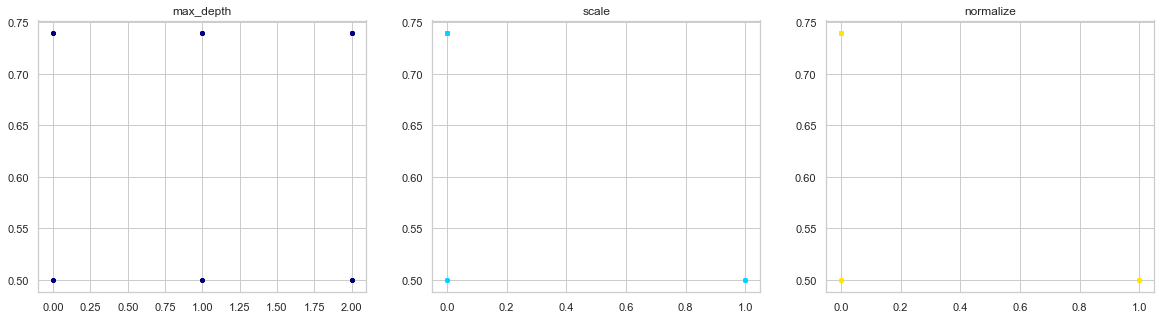

In [ ]:
#parameters = ['max_depth', 'max_features', 'criterion', 'scale', 'normalize'] # decision tree
parameters = ['max_depth', 'scale', 'normalize']
cols = len(parameters)

f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20,5))
cmap = plt.cm.jet

for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, color=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)
    #axes[i].set_ylim([0.9,1.0])

In [ ]:
trial_list = pd.DataFrame(columns = ['max_depth','normalize','scale','auc'])
for t in trials.trials:
    trial_list.loc[len(trial_list)]=[t['misc']['vals']['max_depth'][0],
                               t['misc']['vals']['normalize'][0],
                               t['misc']['vals']['scale'][0],
                               -t['result']['loss']]
#trial_list = trial_list.drop_duplicates().sort_values(['max_depth','normalize','scale'])

In [ ]:
trial_list

max_depth  normalize  scale       auc
0          2.0        0.0    0.0  0.739819
1          2.0        1.0    1.0  0.500000
2          0.0        0.0    1.0  0.500000
3          2.0        1.0    0.0  0.500000
4          2.0        1.0    0.0  0.500000
..         ...        ...    ...       ...
135        2.0        0.0    0.0  0.739819
136        2.0        0.0    0.0  0.739819
137        2.0        0.0    0.0  0.739819
138        2.0        0.0    0.0  0.739819
139        2.0        1.0    1.0  0.500000

[140 rows x 4 columns]